# Cifar-10 이미지 분류

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np

In [2]:
# seed 값 설정
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# 나중에 지정될 변수의 값을 미리 세팅
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 100
DATA_AUGMENTATION = True
NUM_PREDICTIONS = 20
SAVE_DIR = os.path.join(os.getcwd(), 'model')

In [5]:
# The data, split between train and test sets:
(x_train, y_train0), (x_test, y_test0) = cifar10.load_data() #원핫인코딩하기전
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 14s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### 데이터확인

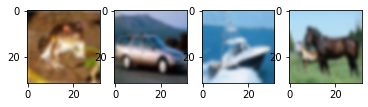

In [6]:
#title 기본 제목 텍스트
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(x_train[0], interpolation="bicubic")
plt.subplot(142)
plt.imshow(x_train[4], interpolation="bicubic")
plt.subplot(143)
plt.imshow(x_train[8], interpolation="bicubic")
plt.subplot(144)
plt.imshow(x_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

In [7]:
#@자료형을 실수로 변환한 후 정규화
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [8]:
#@원핫인코딩 Convert class vectors to binary class matrices.
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train0, NUM_CLASSES)#y_train0을 10개
y_test = to_categorical(y_test0, NUM_CLASSES)
y_train.shape, y_test.shape
#((50000, 10), (10000, 10))

((50000, 10), (10000, 10))

## 모델 정의/설정/학습

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), #필터=마스크=커널 갯수32
                 padding='same',
                 input_shape=x_train.shape[1:], #(50000, 32, 32, 3)에서 shape[1:]은 뒤에 3개만 ㅋ.ㅋ
                 activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [10]:
from tensorflow.keras.optimizers import RMSprop
# initiate RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

In [11]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath = "model/cifar10-aug-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=10)

In [14]:
#여기가바로 data augmentation (구글링 ImageDataGenerator사용법)
datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False,
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,   
    zca_whitening=False,  
    zca_epsilon=1e-06,    
    rotation_range=0,    
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0., 
    zoom_range=0.,  
    channel_shift_range=0.,  
    fill_mode='nearest',
    cval=0.,  
    horizontal_flip=True,  
    vertical_flip=False,   
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0)

datagen.fit(x_train)

In [17]:
#여기추가
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, stratify=y_train, random_state=seed
)

In [18]:
#요기 조금 변경datagen.flow, validation_data
history = model.fit(datagen.flow(x_train, y_train,
                                  batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data = (x_valid, y_valid), #여기변경
                    shuffle=True,
                    callbacks=[early_stopping_callback, checkpointer])#verbose옵션안줌

Epoch 1/100
1172/1172 [==============================] - 20s 17ms/step - loss: 1.6173 - accuracy: 0.4094 - val_loss: 1.4243 - val_accuracy: 0.4793

Epoch 00001: val_loss improved from inf to 1.42434, saving model to model/cifar10-aug-01-1.4243.hdf5
Epoch 2/100
1172/1172 [==============================] - 19s 17ms/step - loss: 1.5190 - accuracy: 0.4460 - val_loss: 1.3793 - val_accuracy: 0.4948

Epoch 00002: val_loss improved from 1.42434 to 1.37927, saving model to model/cifar10-aug-02-1.3793.hdf5
Epoch 3/100
1172/1172 [==============================] - 19s 17ms/step - loss: 1.4487 - accuracy: 0.4770 - val_loss: 1.2761 - val_accuracy: 0.5394

Epoch 00003: val_loss improved from 1.37927 to 1.27614, saving model to model/cifar10-aug-03-1.2761.hdf5
Epoch 4/100
1172/1172 [==============================] - 19s 17ms/step - loss: 1.3953 - accuracy: 0.4972 - val_loss: 1.2929 - val_accuracy: 0.5322

Epoch 00004: val_loss did not improve from 1.27614
Epoch 5/100
1172/1172 [=======================

In [19]:
from tensorflow.keras.models import load_model
model = load_model('model/cifar10-aug-64-0.6474.hdf5')

In [20]:
# 테스트 정확도 출력 
acc = model.evaluate(x_test, y_test, verbose=2)[1]
print(f"Test Accuracy: {acc:.4f}")

313/313 - 1s - loss: 0.6696 - accuracy: 0.7715
Test Accuracy: 0.7715


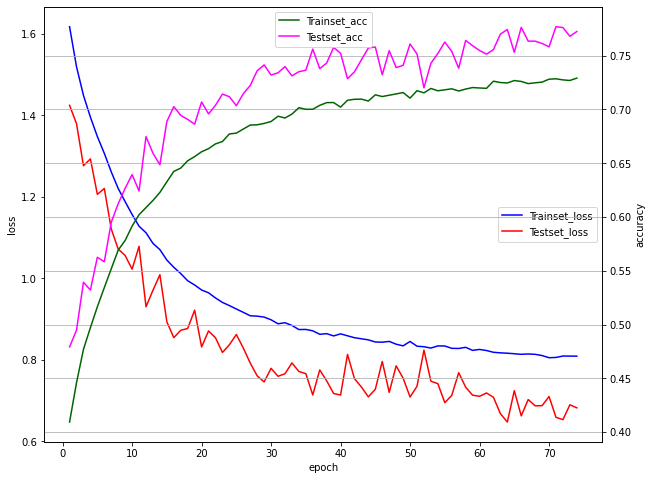

In [25]:
# 검증셋의 오차
y_vloss = history.history['val_loss']
y_vacc =  history.history['val_accuracy']

# 학습셋의 오차
y_loss = history.history['loss']
y_acc =  history.history['accuracy']

# 그래프로 표현
import matplotlib.pyplot as plt
%matplotlib inline
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='center right')
ax1.legend(loc='upper center')
plt.grid()
plt.show()